In [13]:
import numpy as np
import scipy
import scipy.spatial
import matplotlib as mpl
import string
import pyrosetta
import pandas as pd
from collections import Counter
import csv
import glob
import operator
from Bio import SeqIO
from shutil import copyfile
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
aas = 'FIWLVMYCATHGSQRKPNED'

In [14]:
def make_pose2alnMap(alnOrig):
    posePos2OrigAlnPos = []
    for n in range(alnOrig.shape[0]): 
        pose2aln = {}
        seqOrig = alnOrig[n]
        posePos = 1
        for i,alnPos in enumerate(seqOrig):
            if alnPos!=20:
                pose2aln[posePos] = i
                posePos += 1
        posePos2OrigAlnPos.append(pose2aln)
    return posePos2OrigAlnPos

def parse_a3m(filename):
    seqs = []
    table = str.maketrans(dict.fromkeys(string.ascii_lowercase))

    # read file line by line
    for line in open(filename,"r"):
        # skip labels
        if line[0] != '>':
            # remove lowercase letters and right whitespaces
            seqs.append(line.rstrip().translate(table))

    # convert letters into numbers
    aas = 'FIWLVMYCATHGSQRKPNED-'
    alphabet = np.array(list(aas), dtype='|S1').view(np.uint8)
    msa = np.array([list(s) for s in seqs], dtype='|S1').view(np.uint8)
    for i in range(alphabet.shape[0]):
        msa[msa == alphabet[i]] = i

    # treat all unknown characters as gaps
    msa[msa > 20] = 20

    return msa

In [17]:
alnOrigPath = 'aln_seqs.fasta'
alnOrig = parse_a3m(alnOrigPath)
oneBodyTerms = np.loadtxt('TF_weights.txt')
X1_pssm_map = np.loadtxt('TF_weights_annotation.txt', dtype='U9')
pdbids = SeqIO.to_dict(SeqIO.parse(open(alnOrigPath,'r'),"fasta"))
pdb_list = [pdbid for pdbid in pdbids]

In [18]:
posePos2OrigAlnPos = make_pose2alnMap(alnOrig)

In [19]:
use_gaps = False
if use_gaps:
    n_aa_types = 21
else:
    n_aa_types = 20

pssm_length = int(len(oneBodyTerms)/n_aa_types)
pssm_height = n_aa_types
pssm = np.reshape(oneBodyTerms, [pssm_length,pssm_height])

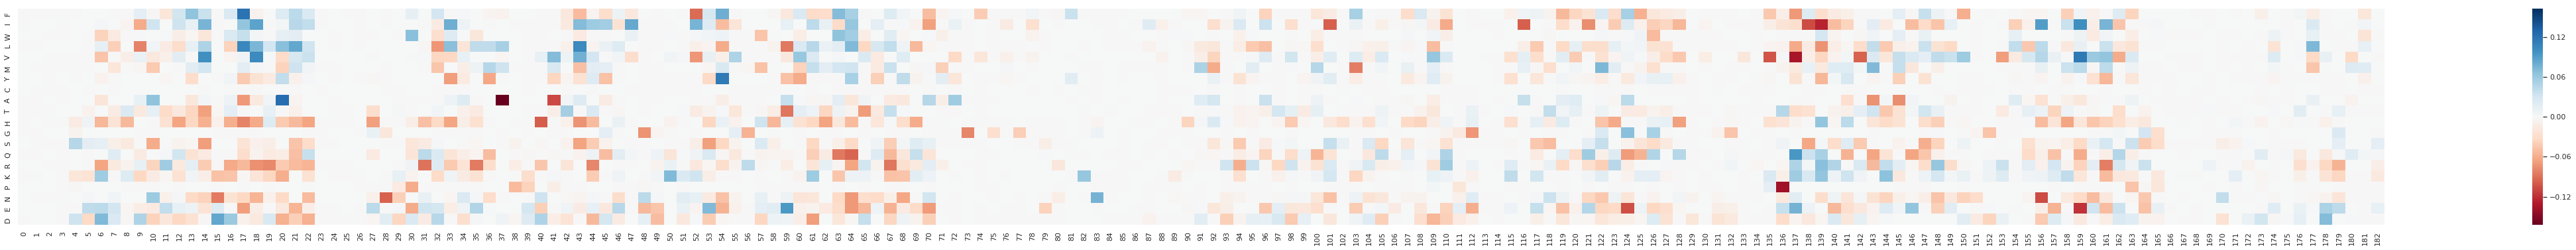

In [21]:
sns.set(rc={'figure.figsize':(80,6.0)})
m = np.max(np.fabs(pssm))
labels = np.transpose(np.reshape(list(aas)*pssm_length, [pssm_length,pssm_height]))
x = pssm.transpose()
g = sns.heatmap(pssm.transpose(), yticklabels=list(aas), cmap='RdBu', vmin=-m, vmax=m )
g.figure.savefig('pssm.pdf', dpi=500)

In [30]:
# How many observations do we have for each amino acid per position?
residues = []
delta_scores = []
res2scores = {}
aa_occurance_count = np.zeros(pssm.shape)

for pos in range(0, alnTrain.shape[1]):
    aas_t, counts = np.unique(alnTrain[:,pos], return_counts=True)
    for aa,c in zip(aas_t,counts):
        if not use_gaps and aa==20:
            continue
        aa_occurance_count[pos, aa] += c

/software/conda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


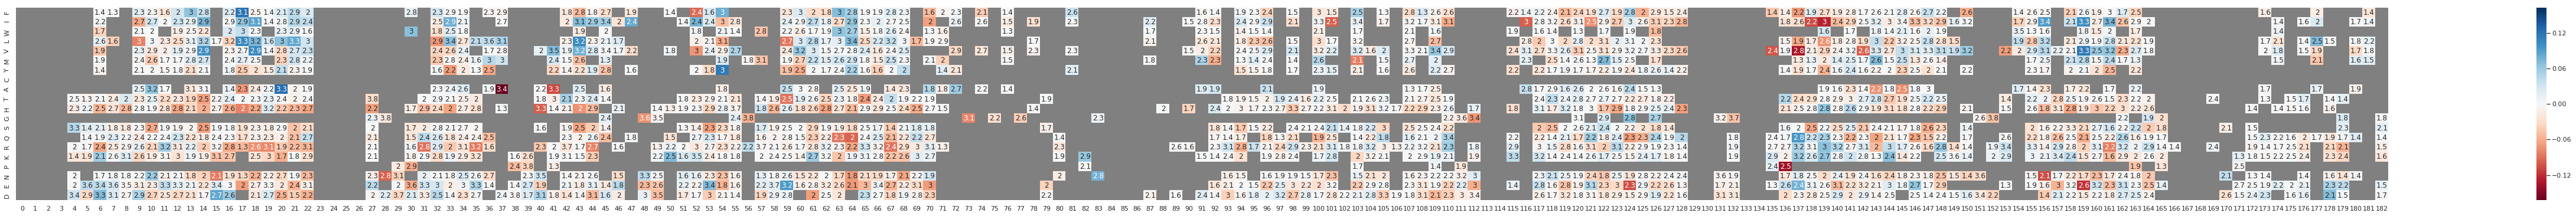

In [27]:
cmap = mpl.cm.get_cmap("RdBu")
cmap.set_bad("grey")

pssm_masked = pssm.copy()
pssm_masked[np.where(aa_occurance_count < 20)] = np.nan

np.set_printoptions(suppress=True)
aa_occurance_count_labels = np.round(np.log(aa_occurance_count)/np.log(10), decimals=1)
aa_occurance_count_labels[np.where(aa_occurance_count==0)] = 0
sns.set(rc={'figure.figsize':(90,6.0)})
m = np.max(np.fabs(pssm))
aa_occurance_count_labels_trans = aa_occurance_count_labels.transpose()
sns.heatmap(pssm_masked.transpose(), yticklabels=list(aas), cmap=cmap, vmin=-m, vmax=m, annot=aa_occurance_count_labels_trans )

If the occurance count is 0, it can mean two things:
1. If all aa in column is 0, the position was not in the alignment used for training, in which case (A) it was really gapped and should be designable.
2. It has for some reason never been tried by Rosetta (Cysteine / Glycine / Prolines / no space) and shouldn't be tried.

In [28]:
rosetta_pssm_order = 'ARNDCQEGHILKMFPSTWYV'
pssm_aas = 'FIWLVMYCATHGSQRKPNED'
aa2no_pssm = {aa:i for i,aa in enumerate(pssm_aas)}
no2aa_pssm = {i:aa for i,aa in enumerate(pssm_aas)}
aa2no_ros = {aa:i for i,aa in enumerate(rosetta_pssm_order)}

# First we set the weight of non-observed amino acids to -1
pssm[np.where(aa_occurance_count==0)] = -100.0

# There will be cases, where for all amino acids with counts, gets
# the same score (0 for instance) [CASE A]. We would probably allow design of those 
# positions (they are equally good and we don't have evidence
# that they are bad). For other positions we might have a distribution
# of amino acid scores [CASE B]. For CASE B we might want to 
# disallow design of amino acids with a score of 0. To do this,
# I set the pssm score of CASE A amino acid to 1. Then we can use
# SeqProfCon to descriminate CASE A and B, assuming that no
# weight from the PSSM fitting was equal or larger than 1.
for i, pssm_vec in enumerate(pssm):
    pssm_vec_for_present_aas = pssm_vec[np.where(aa_occurance_count[i]>0)]
    if len(pssm_vec_for_present_aas) and np.all(pssm_vec_for_present_aas == pssm_vec_for_present_aas[0]) and pssm_vec_for_present_aas[0]!=-1.:
        pssm_vec[np.where(aa_occurance_count[i]>0)] = 100.0
        pssm[i] = pssm_vec

In [29]:
# Make PSSMs for rosetta
rosetta_pssm_order = 'ARNDCQEGHILKMFPSTWYV'
pssm_aas = 'FIWLVMYCATHGSQRKPNED-'
aa2no_pssm = {aa:i for i,aa in enumerate(pssm_aas)}
no2aa_pssm = {i:aa for i,aa in enumerate(pssm_aas)}
aa2no_ros = {aa:i for i,aa in enumerate(rosetta_pssm_order)}

end_str = '\n\n' + '                      K         Lambda\n' + 'PSI Ungapped         0.1334     0.3157\n' + 'PSI Gapped           0.0408     0.2670\n'

for pdbidx,pdb in enumerate(pdb_list):    
    outpssmPath = 'designs_w_pssm/'+pdb.split('/')[-1].replace('.pdb','.pssm')
    pdbres2OrigAlnMap = posePos2OrigAlnPos[pdbidx]
    with open(outpssmPath,'w') as outpssm:
        outpssm.write('\n')
        outpssm.write('Last position-specific scoring matrix computed, weighted observed percentages rounded down, information per position, and relative weight of gapless real matches to pseudocounts\n')
        outpssm.write('           A  R  N  D  C  Q  E  G  H  I  L  K  M  F  P  S  T  W  Y  V   A   R   N   D   C   Q   E   G   H   I   L   K   M   F   P   S   T   W   Y   V\n')
        for pdbres in pdbres2OrigAlnMap:
            origAlnResNum = pdbres2OrigAlnMap[pdbres]
            resn = no2aa_pssm[alnOrig[pdbidx][origAlnResNum]]
            outpssm.write(' ' + str(pdbres) + ' ' + resn + ' ' + ' '.join([str(pssm[origAlnResNum][aa2no_pssm[aa]]) for aa in rosetta_pssm_order]) + '\n')
    # Also write out the occurance counts
    outAACountsPath = 'designs_w_pssm/'+pdb.split('/')[-1].replace('.pdb','.counts')
    pdbres2OrigAlnMap = posePos2OrigAlnPos[pdbidx]
    with open(outAACountsPath,'w') as outCounts:
        outCounts.write('\n')
        outCounts.write('Last position-specific scoring matrix computed, weighted observed percentages rounded down, information per position, and relative weight of gapless real matches to pseudocounts\n')
        outCounts.write('           A  R  N  D  C  Q  E  G  H  I  L  K  M  F  P  S  T  W  Y  V   A   R   N   D   C   Q   E   G   H   I   L   K   M   F   P   S   T   W   Y   V\n')
        for pdbres in pdbres2OrigAlnMap:
            origAlnResNum = pdbres2OrigAlnMap[pdbres]
            resn = no2aa_pssm[alnOrig[pdbidx][origAlnResNum]]
            outCounts.write(' ' + str(pdbres) + ' ' + resn + ' ' + ' '.join([str(aa_occurance_count[origAlnResNum][aa2no_pssm[aa]]) for aa in rosetta_pssm_order]) + '\n')